In [19]:
from __future__ import print_function
from __future__ import division
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
print("PyTorch Version: ",torch.__version__)
print("Torchvision Version: ",torchvision.__version__)

PyTorch Version:  1.7.1
Torchvision Version:  0.8.2


In [20]:
data_dir = "data/base_dataset/"
model_name = "resnet"

num_classes = 6

batch_size = 128

num_epochs = 50
feature_extract = True

In [21]:
Tr_Loss = []
Tr_Accuracy = []
Val_Loss = []
Val_Accuracy = []

def train_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    for epoch in range(num_epochs):
        scheduler.step()
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0
            
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)

                        _, preds = torch.max(outputs, 1)

                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            if phase == 'train':
                Tr_Loss.append(epoch_loss)
                Tr_Accuracy.append(epoch_acc)
            else:
                Val_Loss.append(epoch_loss)
                Val_Accuracy.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f} Lr: {}'.format(phase, epoch_loss, epoch_acc, optimizer.param_groups[0]['lr']))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))

In [22]:
def set_parameter_requires_grad(model, feature_extracting):
    if feature_extracting:
        for param in model.parameters():
            param.requires_grad = False

In [23]:
def initialize_model(model_name, num_classes, feature_extract, use_pretrained=True):
    model_ft = None
    input_size = 0

    if model_name == "resnet":
        """ Resnet18
        """
        model_ft = models.resnet50(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.fc.in_features
        model_ft.fc = nn.Linear(num_ftrs, num_classes)
        input_size = 224

    elif model_name == "alexnet":
        """ Alexnet
        """
        model_ft = models.alexnet(pretrained=use_pretrained)
        set_parameter_requires_grad(model_ft, feature_extract)
        num_ftrs = model_ft.classifier[6].in_features
        model_ft.classifier[6] = nn.Linear(num_ftrs,num_classes)
        input_size = 224

    else:
        print("Invalid model name, exiting...")
        exit()

    return model_ft, input_size

model_ft, input_size = initialize_model(model_name, num_classes, feature_extract, use_pretrained=True)

print(model_ft)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [24]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'validation': transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

print("Initializing Datasets and Dataloaders...")

image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'validation']}
dataloaders_dict = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batch_size, shuffle=True, num_workers=4) for x in ['train', 'validation']}

image_datasets

Initializing Datasets and Dataloaders...


{'train': Dataset ImageFolder
     Number of datapoints: 14034
     Root location: data/base_dataset/train
     StandardTransform
 Transform: Compose(
                RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=PIL.Image.BILINEAR)
                RandomHorizontalFlip(p=0.5)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'validation': Dataset ImageFolder
     Number of datapoints: 3000
     Root location: data/base_dataset/validation
     StandardTransform
 Transform: Compose(
                Resize(size=224, interpolation=PIL.Image.BILINEAR)
                CenterCrop(size=(224, 224))
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

In [26]:
model_ft = model_ft.to(device)

params_to_update = model_ft.parameters()
print("Params to learn:")
if feature_extract:
    params_to_update = []
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            params_to_update.append(param)
            print("\t",name)
else:
    for name,param in model_ft.named_parameters():
        if param.requires_grad == True:
            print("\t",name)

optimizer_ft = optim.SGD(params_to_update, lr=0.01, momentum=0.7)
scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=15, gamma=0.1)

Params to learn:
	 fc.weight
	 fc.bias


In [27]:
criterion = nn.CrossEntropyLoss()

model_ft, hist = train_model(model_ft, dataloaders_dict, criterion, optimizer_ft, num_epochs=num_epochs)

Epoch 0/49
----------
train Loss: 0.6114 Acc: 0.8000 Lr: 0.01
validation Loss: 0.3238 Acc: 0.8923 Lr: 0.01

Epoch 1/49
----------
train Loss: 0.4090 Acc: 0.8557 Lr: 0.01
validation Loss: 0.2780 Acc: 0.9003 Lr: 0.01

Epoch 2/49
----------
train Loss: 0.3843 Acc: 0.8582 Lr: 0.01
validation Loss: 0.2707 Acc: 0.9043 Lr: 0.01

Epoch 3/49
----------
train Loss: 0.3742 Acc: 0.8635 Lr: 0.01
validation Loss: 0.2621 Acc: 0.9047 Lr: 0.01

Epoch 4/49
----------
train Loss: 0.3641 Acc: 0.8661 Lr: 0.01
validation Loss: 0.2716 Acc: 0.9007 Lr: 0.01

Epoch 5/49
----------
train Loss: 0.3574 Acc: 0.8711 Lr: 0.01
validation Loss: 0.2683 Acc: 0.9037 Lr: 0.01

Epoch 6/49
----------
train Loss: 0.3520 Acc: 0.8715 Lr: 0.01
validation Loss: 0.2654 Acc: 0.9017 Lr: 0.01

Epoch 7/49
----------
train Loss: 0.3442 Acc: 0.8750 Lr: 0.01
validation Loss: 0.2673 Acc: 0.8977 Lr: 0.01

Epoch 8/49
----------
train Loss: 0.3444 Acc: 0.8728 Lr: 0.01
validation Loss: 0.2466 Acc: 0.9123 Lr: 0.01

Epoch 9/49
----------
train 

TypeError: cannot unpack non-iterable NoneType object

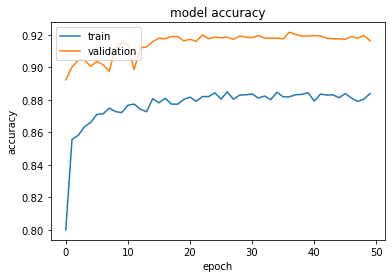

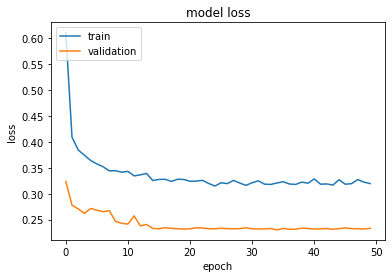

In [28]:
#Accuracy
plt.plot(Tr_Accuracy)
plt.plot(Val_Accuracy)
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

# "Loss"
plt.plot(Tr_Loss)
plt.plot(Val_Loss)
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [32]:
Path = "Reset50_BaseData_AdaptiveLearningRate.pth"
torch.save(model_ft.state_dict(), Path)

In [37]:
model = model_ft.load_state_dict(torch.load("Reset50_BaseData_AdaptiveLearningRate.pth"))
model = model_ft.eval().to(device)

In [38]:
transform = transforms.Compose([
        transforms.RandomResizedCrop(input_size),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [39]:
def get_predictions(model, Loader):
    A_Preds = torch.tensor([]).to(device = device)
    
    for batch in Loader:
        images, labels = batch

        images = images.to(device = device)
        labels = labels.to(device = device)
     
        pred = model(images)
        A_Preds = torch.cat((A_Preds, pred), dim = 0)
        
        return A_Preds

In [40]:
Test_Dataset = datasets.ImageFolder('data/base_dataset/test/', transform)

In [41]:
Pred_Loader = torch.utils.data.DataLoader(Test_Dataset, batch_size = 10, shuffle=True)

In [42]:
def get_num_correct (preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [48]:
classes = 'buildings','forest','glacier','mountains','sea','street'

In [44]:
from sklearn.metrics import confusion_matrix

predlist=torch.zeros(0,dtype=torch.long).to(device)
lbllist=torch.zeros(0,dtype=torch.long).to(device)

with torch.no_grad():
    for i, (inputs, classes) in enumerate(Pred_Loader):
        inputs = inputs.to(device)
        classes = classes.to(device)
        outputs = model_ft(inputs).to(device)
        _, preds = torch.max(outputs, 1)

        predlist=torch.cat([predlist,preds.view(-1)])
        lbllist=torch.cat([lbllist,classes.view(-1)])

conf_mat = confusion_matrix(lbllist.cpu().data.numpy(), predlist.cpu().data.numpy())

class_accuracy = 100 * conf_mat.diagonal() / conf_mat.sum(1)

print(conf_mat)

[[1006    5    4    4   16  109]
 [   3 1130    8   12    6    7]
 [   5    5 1048  189   79    4]
 [   4   14  137 1030  109    3]
 [  11    9   36   62 1001    9]
 [ 105   10   12    8   25 1076]]


In [45]:
from PIL import Image

filename = ("data/base_dataset/test/forest/22.jpg")
#filename = ("C:/Users/Muhammad Atif Butt/Desktop/4.jpg")
input_image = Image.open(filename)

In [46]:
preprocess = transforms.Compose([
        transforms.Resize(input_size),
        transforms.CenterCrop(input_size),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

input_tensor = preprocess(input_image).to(device)
input_batch = input_tensor.unsqueeze(0)
input_batch.shape

torch.Size([1, 3, 224, 224])

tensor([1.5154e-02, 9.7750e-01, 5.5037e-05, 2.6094e-04, 1.2863e-03, 5.7449e-03],
       device='cuda:0')
tensor(1, device='cuda:0')
forest


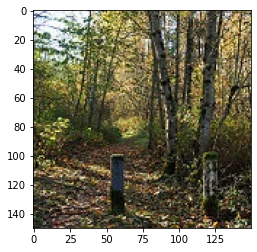

In [49]:
with torch.no_grad():
    output = model(input_batch)

per = torch.nn.functional.softmax(output[0], dim=0)
index = torch.argmax(per, dim = 0)

plt.imshow(input_image)
print(per)
print(index)
print(classes[index])